# LETR Basic Usage Demo

In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import torchvision.transforms.functional as functional
import torch.nn.functional as F
from models import build_model
from util.misc import nested_tensor_from_tensor_list

/home/alexis/miniconda3/envs/deepl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/alexis/miniconda3/envs/deepl/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = functional.normalize(image, mean=self.mean, std=self.std)
        return image

class ToTensor(object):
    def __call__(self, img):
        return functional.to_tensor(img)

def resize(image, size, max_size=None):
    # size can be min_size (scalar) or (w, h) tuple
    def get_size_with_aspect_ratio(image_size, size, max_size=None):
        w, h = image_size
        if max_size is not None:
            min_original_size = float(min((w, h)))
            max_original_size = float(max((w, h)))
            if max_original_size / min_original_size * size > max_size:
                size = int(round(max_size * min_original_size / max_original_size))
        if (w <= h and w == size) or (h <= w and h == size):
            return (h, w)
        if w < h:
            ow = size
            oh = int(size * h / w)
        else:
            oh = size
            ow = int(size * w / h)
        return (oh, ow)

    def get_size(image_size, size, max_size=None):
        if isinstance(size, (list, tuple)):
            return size[::-1]
        else:
            return get_size_with_aspect_ratio(image_size, size, max_size)

    size = get_size(image.size, size, max_size)
    rescaled_image = functional.resize(image, size)

    return rescaled_image

class Resize(object):
    def __init__(self, sizes, max_size=None):
        assert isinstance(sizes, (list, tuple))
        self.sizes = sizes
        self.max_size = max_size

    def __call__(self, img):
        size = self.sizes
        return resize(img, size, self.max_size)



## Load Model Pre-trained Weights

In [3]:
# obtain checkpoints
# checkpoint = torch.load('../exp/res101_stage2_focal/checkpoints/checkpoint0024.pth', map_location='cpu')
checkpoint = torch.load('../exp/res50_stage1_848/checkpoints/checkpoint.pth', map_location='cpu')

# load model
args = checkpoint['args']
args.device = 'cpu'
model, _, postprocessors = build_model(args)
model.load_state_dict(checkpoint['model'])
model.eval()



/home/alexis/miniconda3/envs/deepl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

## Load Demo Image

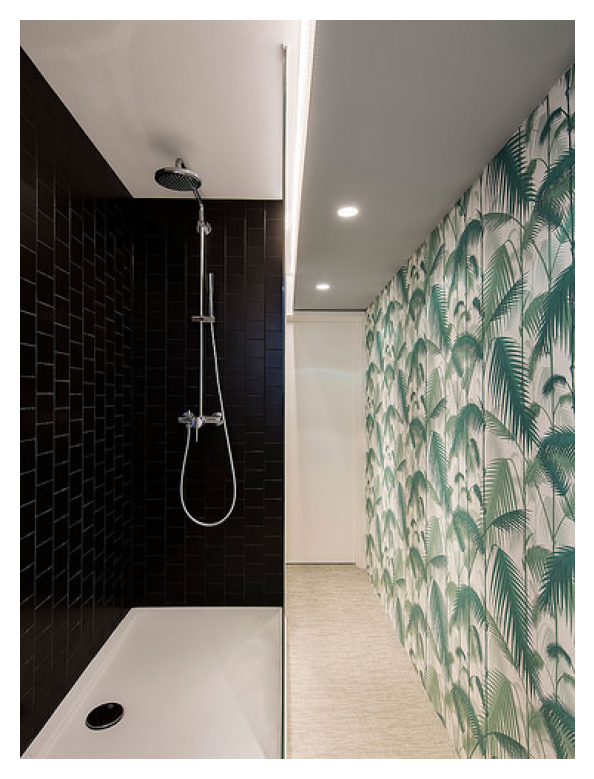

In [4]:
# load image
raw_img = plt.imread('../figures/demo.png')
h, w = raw_img.shape[0], raw_img.shape[1]
orig_size = torch.as_tensor([int(h), int(w)])

# normalize image
test_size = 1100
normalize = Compose([
        ToTensor(),
        Normalize([0.538, 0.494, 0.453], [0.257, 0.263, 0.273]),
        Resize([test_size]),
    ])
img = normalize(raw_img)
inputs = nested_tensor_from_tensor_list([img])
plt.axis('off')
plt.imshow(raw_img)

## Model Inference

In [5]:

outputs = model(inputs)
outputs

/home/alexis/LETR_euler/src/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


{'pred_logits': tensor([[[ 0.0254, -6.3755,  3.1101],
          [ 0.1965, -7.8253,  2.6679],
          [ 2.2470, -9.5044,  1.7048],
          ...,
          [ 0.5888, -7.7662,  2.8614],
          [ 2.6811, -9.8340,  0.4481],
          [ 0.6040, -8.6995,  3.4342]]], grad_fn=<SelectBackward0>),
 'pred_lines': tensor([[[0.3075, 0.8906, 0.3274, 0.8872],
          [0.8688, 0.7909, 0.8894, 0.7858],
          [0.5482, 0.2652, 0.5614, 0.2613],
          ...,
          [0.6544, 0.8769, 0.6705, 0.8755],
          [0.9243, 0.6478, 0.9521, 0.6408],
          [0.3994, 0.4698, 0.4111, 0.4566]]], grad_fn=<SelectBackward0>),
 'aux_outputs': [{'pred_logits': tensor([[[ 2.8460, -9.3426, -0.1533],
            [ 2.7831, -9.3071, -0.0901],
            [ 3.0810, -9.6482,  0.0228],
            ...,
            [ 2.8377, -9.3333, -0.1095],
            [ 2.9228, -9.6865, -0.0788],
            [ 2.9869, -9.7115, -0.0767]]], grad_fn=<UnbindBackward0>),
   'pred_lines': tensor([[[0.6734, 0.7466, 0.6915, 0.7403],


In [9]:
for key, value in outputs.items():
    print(key)

pred_logits
pred_lines
aux_outputs


In [17]:
len(outputs['aux_outputs'][4])

2

## Post-processing Results

In [6]:
out_logits, out_line = outputs['pred_logits'], outputs['pred_lines']
prob = F.softmax(out_logits, -1)
scores, labels = prob[..., :-1].max(-1)
img_h, img_w = orig_size.unbind(0)
scale_fct = torch.unsqueeze(torch.stack([img_w, img_h, img_w, img_h], dim=0), dim=0)
lines = out_line * scale_fct[:, None, :]
lines = lines.view(1000, 2, 2)
lines = lines.flip([-1])# this is yxyx format
scores = scores.detach().numpy()
keep = scores >= 0.7
keep = keep.squeeze()
lines = lines[keep]
lines = lines.reshape(lines.shape[0], -1)




## Plot Inference Results

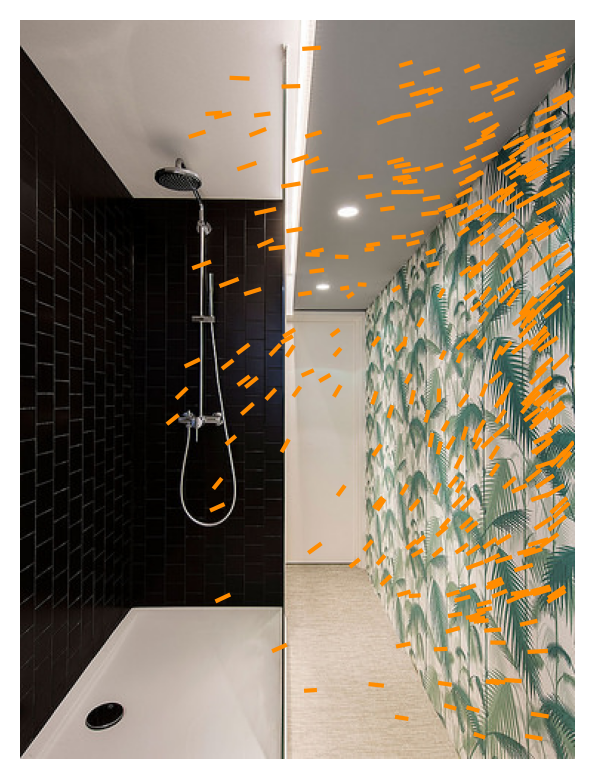

In [7]:

fig = plt.figure()
plt.imshow(raw_img)
for tp_id, line in enumerate(lines):
    y1, x1, y2, x2 = line # this is yxyx
    p1 = (x1, y1)
    p2 = (x2, y2)
    plt.plot([p1[0].detach().numpy(), p2[0].detach().numpy()], [p1[1].detach().numpy(), p2[1].detach().numpy()], linewidth=1.5, color='darkorange', zorder=1)
plt.axis('off')


#plt.savefig("../figures/demo_result.png", dpi=300, bbox_inches='tight', pad_inches = 0)
#plt.close(fig)
plt.show()


In [8]:
plt.show()